In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Q1 : The stock market

In [2]:
import random as rnd
from numba import njit

In [3]:
# states
states = {'Bull market':0, 'Bear market':1, 'Stagnant market':2}

# transition matrix
T = np.array([0.9,0.075,0.025,0.15,0.8,0.05,0.25,0.25,0.5]).reshape(3,3)
#T

In [36]:
# routine for whole chain
def stock_chain(states, T, num_steps):
    # initial state, initialized chain
    x0 = rnd.randint(0,2)
    chain = [x0,]
    
    for i in range(1, num_steps):
        chain.append(rnd.choices(list(states.values()), weights=T[chain[i-1]])[0])
    
    return chain

Check if % of days in each state converges with increasing number of steps:

In [23]:
def stock_counts(N):
    zeros = []
    ones = []
    twos = []
    
    for n in N:
        nchain = stock_chain(states, T, n)
        counts = np.unique(nchain, return_counts=True)[1]
        zeros.append(counts[0]/n*100)
        ones.append(counts[1]/n*100)
        twos.append(counts[2]/n*100)
    
    return zeros, ones, twos

In [24]:
N = 10**np.arange(2,7)

stock_counts(N)

([61.0, 62.7, 64.07000000000001, 62.958999999999996, 62.4591],
 [30.0, 31.5, 29.509999999999998, 30.875999999999998, 31.299599999999998],
 [9.0, 5.800000000000001, 6.419999999999999, 6.165, 6.241300000000001])

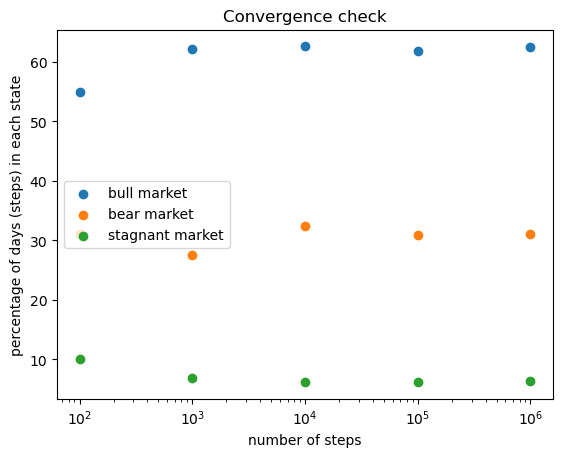

In [25]:
fig = plt.figure()
ax = fig.add_subplot()

ax.set_title('Convergence check')
ax.scatter(N, stock_counts(N)[0], label='bull market')
ax.scatter(N, stock_counts(N)[1], label='bear market')
ax.scatter(N, stock_counts(N)[2], label='stagnant market')
ax.set_xscale('log')
ax.set_xlabel('number of steps')
ax.set_ylabel('percentage of days (steps) in each state')
ax.legend(loc='best');

I found out random.choices is not implemented in numba...
Let me write another version of the chain:

In [59]:
def stock_chain_2(states, T, num_steps):
    # selects an index based on a list of cumulative probabilities
    def weighted_choice(cumulative_weights):
        r = rnd.random()
        for i, cw in enumerate(cumulative_weights):
            if r < cw:
                return i
        return len(cumulative_weights) - 1  # to handle rounding errors

    # now I compute the evolution of the chain (again)
    x0 = rnd.randint(0,2)
    chain = [x0,]
    
    for i in range(1, num_steps):
        cumulative_weights = np.cumsum(T[chain[i-1]])
        chain.append(weighted_choice(cumulative_weights))

    return chain

In [56]:
c_stock_chain_2= njit(stock_chain_2)

In [57]:
%timeit c_stock_chain_2(list(states.values()), T, 1_000)

149 μs ± 16.5 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [58]:
%timeit stock_chain_2(list(states.values()), T, 1_000)

3.41 ms ± 295 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Q2 : Consistent plotting

In [22]:
def myplot(function):
    def wrapper(*args, **kwargs):
        import matplotlib.pyplot as plt
        import matplotlib as mpl

        mpl.rcParams['axes.grid'] = True
        mpl.rcParams['axes.edgecolor'] = 'grey'
        mpl.rcParams['axes.labelcolor'] = 'grey'
        mpl.rcParams['lines.linestyle'] = '-.'
        plt.rcParams.update({'font.size': 14})
        
        fig = function(*args, **kwargs)
    return wrapper

In [23]:
x = np.linspace(0,10,100)
y = x**2 + x

In [24]:
@myplot
def generic_plot(x, y, label):
    fig = plt.figure(figsize = (4,4))
    ax = fig.add_subplot()
    ax.plot(x,y, label=label)
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$f(x)$')
    return fig

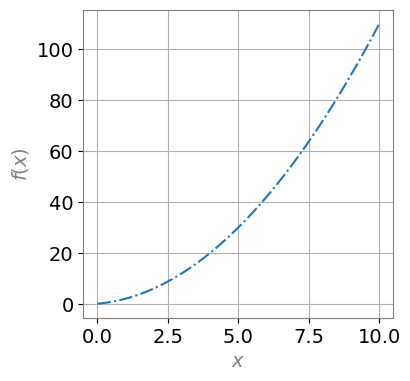

In [25]:
generic_plot(x, y, r'$x^2 + x$')